In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [17]:
nop.plot_setup()
cmap = "inferno"

In [18]:
def get_name(N_nodes, nn, sd_llf):
    return str(
        "../testing/@MA1-FirstBuilder/output/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
        + ".h5"
    )


def get_mu(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["mu_nodes"]


def get_kld(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["kl_divs"]

In [19]:
# Parameter ranges used for simulations
N_arr = [1, 2, 150]
nn_arr = [0, 1, 4, 8, 12, 16, 20]
sd_llf_arr = np.round(np.arange(0.5, 5.1, 0.5), 1)
t_arr = np.arange(0, len(get_kld(N_arr[-1], nn_arr[-1], sd_llf_arr[-1])), 1)
nn_arr[2:]

[4, 8, 12, 16, 20]

In [48]:
# Initialize xarray Dataset
tmp_arr = np.empty((len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), max(N_arr)))
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "time": t_arr,
        "node": np.arange(max(N_arr)),
    },
)
del tmp_arr

# Populate the Dataset
for N in N_arr:
    for sd_llf in sd_llf_arr:
        if N == 1:
            nn = 0
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_mu(
                N, nn, sd_llf
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_kld(
                N, nn, sd_llf
            )
        elif N == 2:
            nn = 1
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_mu(
                N, nn, sd_llf
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = get_kld(
                N, nn, sd_llf
            )
        else:
            for nn in nn_arr[2:]:
                ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = (
                    get_mu(N, nn, sd_llf)
                )
                ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(150))] = (
                    get_kld(N, nn, sd_llf)
                )
#
# for i, N in enumerate(N_arr):
#    for j, nn in enumerate(nn_arr):
#        for k, sd_llf in enumerate(sd_llf_arr):
#            ds["mu"].loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N))] = get_mu(
#                N, nn, sd_llf
#            )
#            ds["kld"].loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N))] = get_kld(
#                N, nn, sd_llf
#            )
#
# df = ds.to_dataframe()

ds

<xarray.Dataset> Size: 25MB
Dimensions:  (N: 3, nn: 7, sd_llf: 5, time: 101, node: 150)
Coordinates:
  * N        (N) int64 24B 1 2 150
  * nn       (nn) int64 56B 0 1 4 8 12 16 20
  * sd_llf   (sd_llf) float64 40B 0.5 1.0 1.5 2.0 2.5
  * time     (time) int64 808B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, node) float64 13MB 0.0 0.0 ... 0.09452
    kld      (N, nn, sd_llf, time, node) float64 13MB 1.856 1.856 ... 0.5497

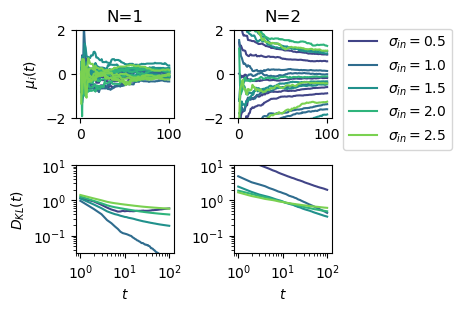

In [179]:
# <KLD>(t) for N=1,2 -- 1 plot each over sd_llf_arr

N_range = np.arange(0, 150, int(150 / 4))
N_tmp = [1, 2]
time = ds.time.values[1:]
x = len(N_tmp)
y = 2
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))

# mu(t) figure
i = 0
color = nop.get_colorcycle(N_colors=len(sd_llf_arr))
for j, N in enumerate(N_tmp):
    if N == 1:
        nn = 0
    elif N == 2:
        nn = 1
    else:
        break
    for k, sd_llf in enumerate(sd_llf_arr):
        ax[i, j].plot(
            time,
            ds.mu.sel(N=N, nn=nn, sd_llf=sd_llf, time=time, node=N_range),
            color=color[k],
        )
        ax[i, j].plot(
            0,
            10,
            color=color[k],
            label="$\sigma_{in}=$" + str(sd_llf),
        )
    ax[i, j].set_ylim((-2, 2))
ax[0, 0].set_title("N=1")
ax[0, 1].set_title("N=2")
ax[0, 0].set_ylabel("$\mu_i(t)$")
# ax[0, 1].legend(bbox_to_anchor=(1.05, 1.2), loc="upper left")

# <KLD(t)>_runs figure
N_range = np.arange(0, 150)
i = 1
for j, N in enumerate(N_tmp):
    if N == 1:
        nn = 0
    elif N == 2:
        nn = 1
    else:
        break
    for k, sd_llf in enumerate(sd_llf_arr):
        ax[i, j].plot(
            time,
            ds.kld.sel(N=N, nn=nn, sd_llf=sd_llf, time=time, node=N_range).mean(
                dim="node"
            ),
            color=color[k],
        )
    ax[i, j].set_xlabel("$t$")
    ax[i, j].set_ylim((10**-1.5, 10**1))
    ax[i, j].loglog()
ax[1, 0].set_ylabel("$D_{KL}(t)$")


ax[0, 1].legend(bbox_to_anchor=(1.05, 1.09), loc="upper left")

/tmp/ipykernel_57226/486051040.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i].set_yscale("log")
/home/jens/conda/envs/neuro_op/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


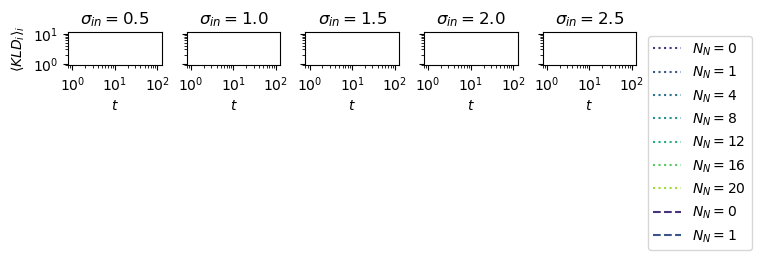

In [31]:
# <KLD>(t) -- 1 plot per sd_in
N_tmp = 150
sd_llf_arr = ds["sd_llf"].values[0:5]
nn_arr = ds["nn"].values
t_tmp = ds.time.values[1:]
x = len(sd_llf_arr)
y = 1
fig, ax = plt.subplots(y, x, figsize=(1.5 * x, 2 * y), sharex=True, sharey=True)
for i, sd_llf in enumerate(sd_llf_arr):
    ax[i].set_prop_cycle(color=nop.get_colorcycle(len(nn_arr)))
    ds_tmp = ds.kld.sel(N=N_tmp, sd_llf=sd_llf, node=range(N_tmp), time=t_arr[1:]).mean(
        dim="node"
    )
    for j in nn_arr:
        ax[i].plot(ds_tmp.time, ds_tmp.sel(nn=j), ls=":", label="$N_N=$" + str(j))

# Great, now let's add results for N=1 and N=2
# Fix nn, as variable was not used/usable when N=1, N=2
for k, N_tmp in enumerate([1, 2]):
    for i, sd_llf in enumerate(sd_llf_arr):
        ax[i].plot(
            t_tmp,
            ds.kld.sel(
                N=N_tmp, nn=nn_arr[0], sd_llf=sd_llf, node=range(N_tmp), time=t_tmp
            ).mean(dim="node"),
            ls="--",
            label="$N_N=$" + str(N_tmp - 1),
            #            color="tab:blue",
        )

# Formatting...
for i, sd_llf in enumerate(sd_llf_arr):
    ax[i].set_title("$\sigma_{in} = $" + str(sd_llf))
    ax[i].set_xlabel("$t$")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    if i == 0:
        ax[i].set_ylabel("$\langle KLD_i \\rangle_i$")
    if i == len(sd_llf_arr) - 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1.1), loc="upper left")

In [8]:
# fig.savefig("fig/@MA1-KLD.pdf")

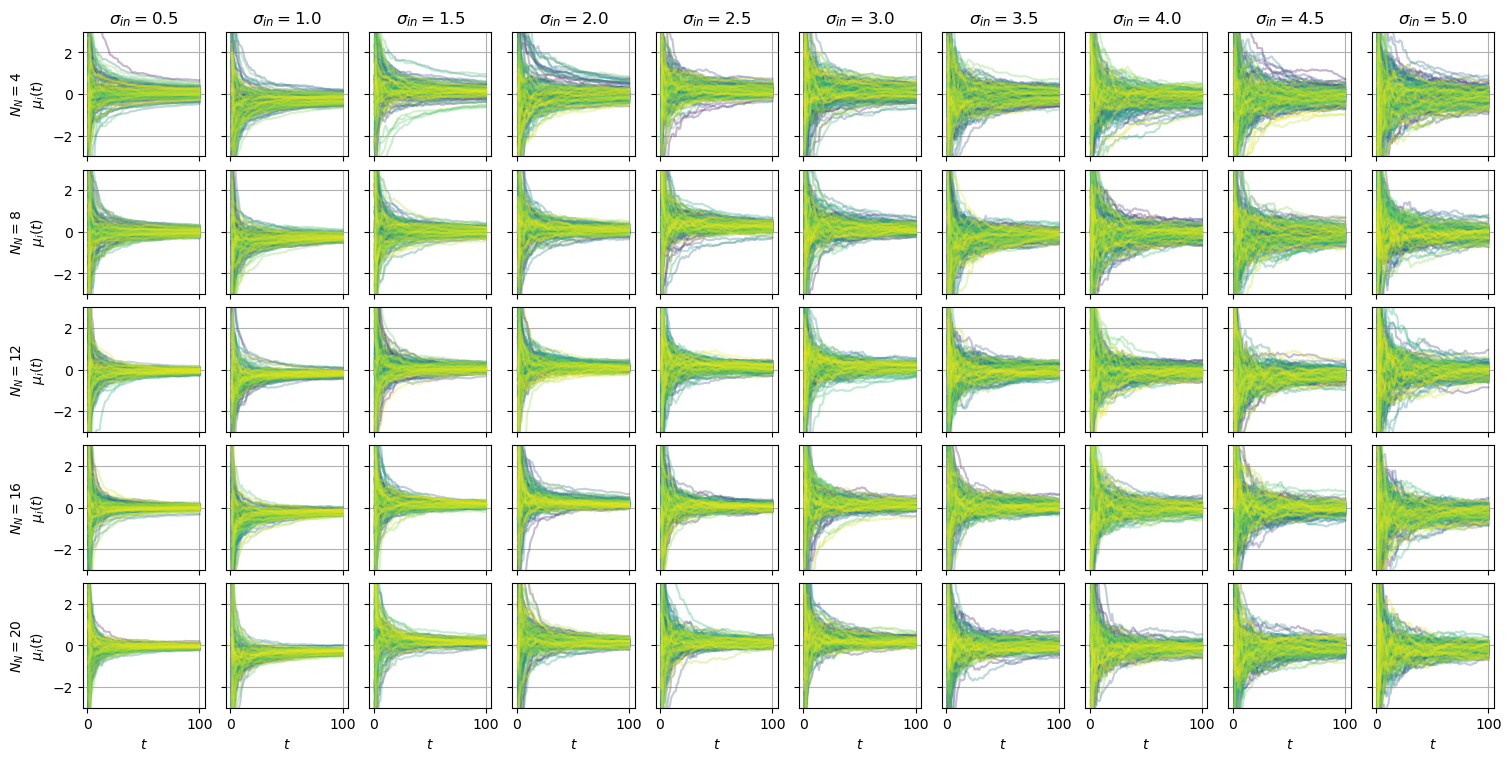

In [9]:
# Having dealt with KLD, let's now look at the mu values over time
N_tmp = 150
sd_llf_arr = ds["sd_llf"]
nn_arr = ds["nn"]
t_tmp = ds["time"][1:]

x = len(sd_llf_arr)
y = len(nn_arr)
fig, ax = plt.subplots(
    y,
    x,
    figsize=(1.5 * x, 1.5 * y),
    sharex=True,
    sharey=True,
)
for i, nn in enumerate(nn_arr):
    for j, sd_llf in enumerate(sd_llf_arr):
        ax[i, j].set_prop_cycle(color=nop.get_colorcycle(N_tmp))
        ax[i, j].plot(
            t_tmp,
            ds.mu.sel(N=N_tmp, nn=nn, sd_llf=sd_llf, node=range(N_tmp), time=t_tmp),
            alpha=0.3,
            #            color="tab:blue",
        )
        ax[i, j].grid()
        ax[i, j].set_ylim((-3, 3))
        if i == 0:
            ax[i, j].set_title("$\sigma_{in}=$" + str(np.round(float(sd_llf), 1)))
        if j == 0:
            ax[i, j].set_ylabel("$N_N=$" + str(int(nn)) + "\n$\mu_i(t)$")
        if i == len(nn_arr) - 1:
            ax[i, j].set_xlabel("$t$")

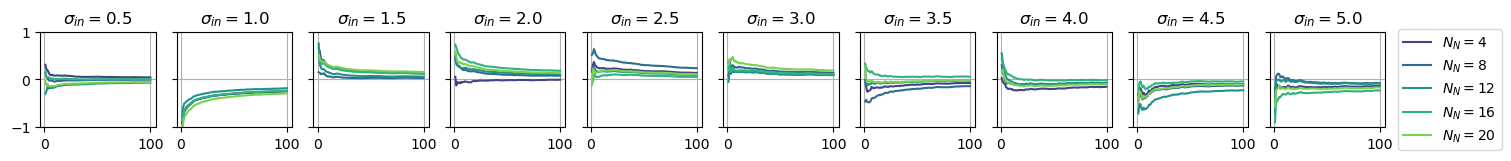

In [10]:
# This does not tell us a lot... Let's try to plot the mean and std of mu over time
N_tmp = 150
sd_llf_arr = ds["sd_llf"]
nn_arr = ds["nn"]
t_tmp = ds["time"][1:]

x = len(sd_llf_arr)
y = 1
fig, ax = plt.subplots(
    y,
    x,
    figsize=(1.5 * x, 1.5 * y),
    sharex=True,
    sharey=True,
)
ax[0].set_ylim((-1, 1))
for i, sd_llf in enumerate(sd_llf_arr):
    ax[i].set_prop_cycle(color=nop.get_colorcycle(len(nn_arr)))
    for j, nn in enumerate(nn_arr):
        ax[i].plot(
            t_tmp,
            ds.mu.sel(
                N=N_tmp, nn=nn, sd_llf=sd_llf, node=range(N_tmp), time=t_tmp
            ).mean(dim="node"),
            label="$N_N=$" + str(int(nn)),
        )
    ax[i].grid()
    ax[i].set_title("$\sigma_{in}=$" + str(np.round(float(sd_llf), 1)))
    if i == len(sd_llf_arr) - 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1.1), loc="upper left")

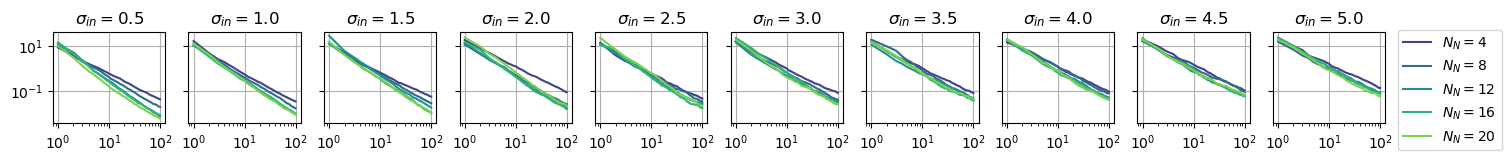

In [11]:
N_tmp = 150
sd_llf_arr = ds["sd_llf"]
nn_arr = ds["nn"]
t_tmp = ds["time"][1:]

x = len(sd_llf_arr)
y = 1
fig, ax = plt.subplots(
    y,
    x,
    figsize=(1.5 * x, 1.5 * y),
    sharex=True,
    sharey=True,
)
# ax[0].set_ylim((-1,1))
for i, sd_llf in enumerate(sd_llf_arr):
    ax[i].set_prop_cycle(color=nop.get_colorcycle(len(nn_arr)))
    for j, nn in enumerate(nn_arr):
        ax[i].plot(
            t_tmp,
            ds.mu.sel(N=N_tmp, nn=nn, sd_llf=sd_llf, node=range(N_tmp), time=t_tmp).var(
                dim="node"
            ),
            label="$N_N=$" + str(int(nn)),
        )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].grid()
    ax[i].set_title("$\sigma_{in}=$" + str(np.round(float(sd_llf), 1)))
    if i == len(sd_llf_arr) - 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1.1), loc="upper left")